##### The implementation of a sequential hybrid anomaly detection model using Isolation Forest and SVM begins by loading and cleaning your data. Then, select crucial features and split the data into training and testing sets. Standardize the features to ensure a uniform scale. First, fit an Isolation Forest to isolate potential anomalies quickly, followed by an SVM to refine anomaly detection with a precise classification boundary. Evaluate the model's performance using precision, recall, F1-score, and a confusion matrix to assess accuracy and sensitivity. This method combines the strengths of both models for robust anomaly detection.

In [4]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 88302 to 73828
Data columns (total 81 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id.orig_p                 50000 non-null  int64  
 1   id.resp_p                 50000 non-null  int64  
 2   flow_duration             50000 non-null  float64
 3   fwd_pkts_tot              50000 non-null  int64  
 4   bwd_pkts_tot              50000 non-null  int64  
 5   fwd_data_pkts_tot         50000 non-null  int64  
 6   bwd_data_pkts_tot         50000 non-null  int64  
 7   fwd_pkts_per_sec          50000 non-null  float64
 8   bwd_pkts_per_sec          50000 non-null  float64
 9   flow_pkts_per_sec         50000 non-null  float64
 10  down_up_ratio             50000 non-null  float64
 11  fwd_header_size_tot       50000 non-null  int64  
 12  fwd_header_size_min       50000 non-null  int64  
 13  fwd_header_size_max       50000 non-null  int64  
 14  bw

C:\Users\sebha\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [24] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\sebha\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


              precision    recall  f1-score   support

           0       1.00      0.40      0.57      2349
           1       0.84      1.00      0.92      7651

    accuracy                           0.86     10000
   macro avg       0.92      0.70      0.74     10000
weighted avg       0.88      0.86      0.83     10000

Precision: 1.0
Recall: 0.399318859088974
F1 Score: 0.5707331913599026


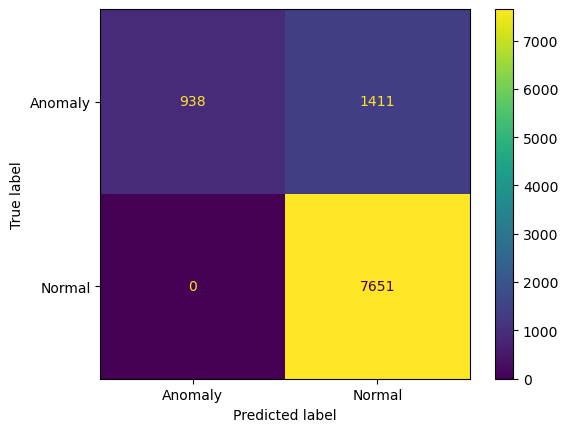

In [5]:

def hybrid_anomaly_detection():
    
    data1 = pd.read_csv('rt_test.csv')
        
    data = data1.sample(n=50000, random_state=5)
    
    data = data.drop(['proto','service','Attack_type'], axis=1)
    data.dropna(axis=0, inplace=True)

    for column in data.columns:
        data[column] = pd.to_numeric(data[column], errors='coerce')
        
    data.info()
    
    # Preprocessing
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    
#     sns.pairplot(data, kind='scatter')
#     plt.title('Scatter Plot')
#     plt.show()
    
    #convert all the values in the columns into numeric
    for column in data.columns:
        data[column] = pd.to_numeric(data[column], errors='coerce')
    
    X = data.drop('payload_bytes_per_second', axis=1)  # This is the target column
    y_cont = data['payload_bytes_per_second']

    # First, binarize `y` based on a chosen threshold.
    y = np.where(y_cont > 1000, 1, 0)  # Define `threshold` based on your domain knowledge
   
    
    # Select top k features; k might be adjusted based on the dataset
    selector = SelectKBest(f_classif, k=15)
    X_selected = selector.fit_transform(X, y)
  
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Phase 1: Train Isolation Forest on the training data
    iso_forest = IsolationForest(random_state=42)
    iso_forest.fit(X_train)
    # Predict on the training data to filter for normal data only
    train_preds = iso_forest.predict(X_train)

    # Filter normal data as input for the SVM
    X_train_filtered = X_train[train_preds == 1]
    y_train_filtered = y_train[train_preds == 1]

    # Phase 2: Train SVM on the filtered normal data
    svm = SVC(kernel='rbf', gamma='auto', random_state=42)
    svm.fit(X_train_filtered, y_train_filtered)

    # Evaluate on the original full test dataset
    svm_predictions = svm.predict(X_test)

    # Calculate precision, recall, and F1 score
    precision = precision_score(y_test, svm_predictions, pos_label=0)
    recall = recall_score(y_test, svm_predictions, pos_label=0)
    f1 = f1_score(y_test, svm_predictions, pos_label=0)

    # Print metrics
    
    print(classification_report(y_test, svm_predictions))
    
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, svm_predictions, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly', 'Normal'])
    disp.plot()
    plt.show()

# Assuming X and y are your dataset's features and labels respectively
hybrid_anomaly_detection()
